# Noise variance experiment

In [105]:
import os 
import torch

def load_all_batches(path : str, max_num_batches : int=None) -> dict[str, torch.Tensor]:
    # during inference, the samples are saved as batches 
    # this function concatenates all batches into a single list
    
    # find all files on the form batch_*.pt
    files = [f for f in os.listdir(path) if f.startswith("batch_") and f.endswith(".pt")]
    files.sort()
    if max_num_batches is not None:
        files = files[:max_num_batches]
    x0s, x1s, x0_recons, trajectories = [], [], [], []
    for file in files:
        batch = torch.load(os.path.join(path, file), weights_only=True)
        x0s.append(batch["x0"])
        x1s.append(batch["x1"])
        x0_recons.append(batch["x0_recon"])
        trajectories.append(batch["trajectory"])
    # concatenate all batches into a single tensor
    x0 = torch.cat(x0s, dim=0)
    x1 = torch.cat(x1s, dim=0)
    x0_recon = torch.cat(x0_recons, dim=0)
    if trajectories[0] is not None:
        trajectories = torch.cat(trajectories, dim=1)
    return {
        "x0": x0,
        "x1": x1,
        "x0_recon": x0_recon,
        "trajectory": trajectories
    }


model_to_name = {
    'mel_sto': 'DSB Log Mel',
    'stft_sto': 'DSB STFT',
    'stft_det': 'DSB STFT',
    'gfb': 'GFB',
    'baseline': 'Baseline',
    'esdsb_sto': 'DSB Mel',
    'baseline': 'Baseline',
    'esdsb_det': 'DSB Mel (Deterministic)',
    'SPADE': 'SPADE',
}

model_to_color = {
    'mel_sto': '#4E79A7',
    'stft_sto': '#F28E2B',
    'stft_det': '#F28E2B',
    'gfb': '#E15759',
    'esdsb_sto': '#76B7B2',
    'baseline': '#59A14F',
    'esdsb_det': '#FF9DA7',
    'SPADE': '#B07AA1',
}

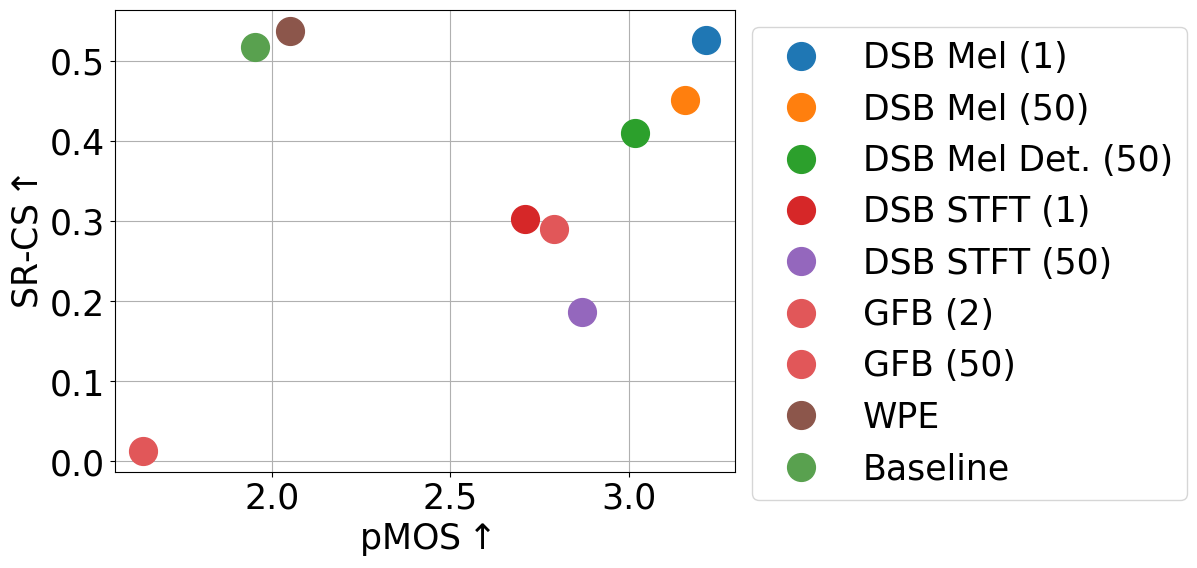

In [ ]:
import matplotlib.pyplot as plt

what_test = "rir"
which_models = {
    'esdsb_sto_1': 'DSB Mel (1)',
    'esdsb_sto_50': 'DSB Mel (50)',
    'esdsb_det_50': 'DSB Mel Det. (50)',
    'stft_sto_1': 'DSB STFT (1)',
    'stft_sto_50': 'DSB STFT (50)',
    'gfb_2': 'GFB (2)',
    'gfb_50': 'GFB (50)',
    'WPE': 'WPE',
    'baseline': r'Baseline',
}

fig, axs = plt.subplots(1, 1, figsize=(8, 6))
plt.rcParams.update({'font.size': 25})


for model in which_models.keys():
    path = f"test_results/test_{what_test}/{model}/metrics.pt"
    metrics = torch.load(path, weights_only=True)
    mos = torch.tensor(metrics['dnsmos']).mean()
    wer = torch.tensor(metrics['srcs']).mean()
    axs.plot(mos, wer, 'o', label=which_models[model], markersize=20)

axs : plt.Axes
axs.set_xlabel(r"pMOS$\uparrow$")
axs.set_ylabel(r"SR-CS$\uparrow$", rotation=90)
axs.legend(loc='upper left', bbox_to_anchor=(1, 1))
axs.grid(True)
plt.savefig(f"test_results/mos_vs_srcs_{what_test}.png", bbox_inches='tight', dpi=300)

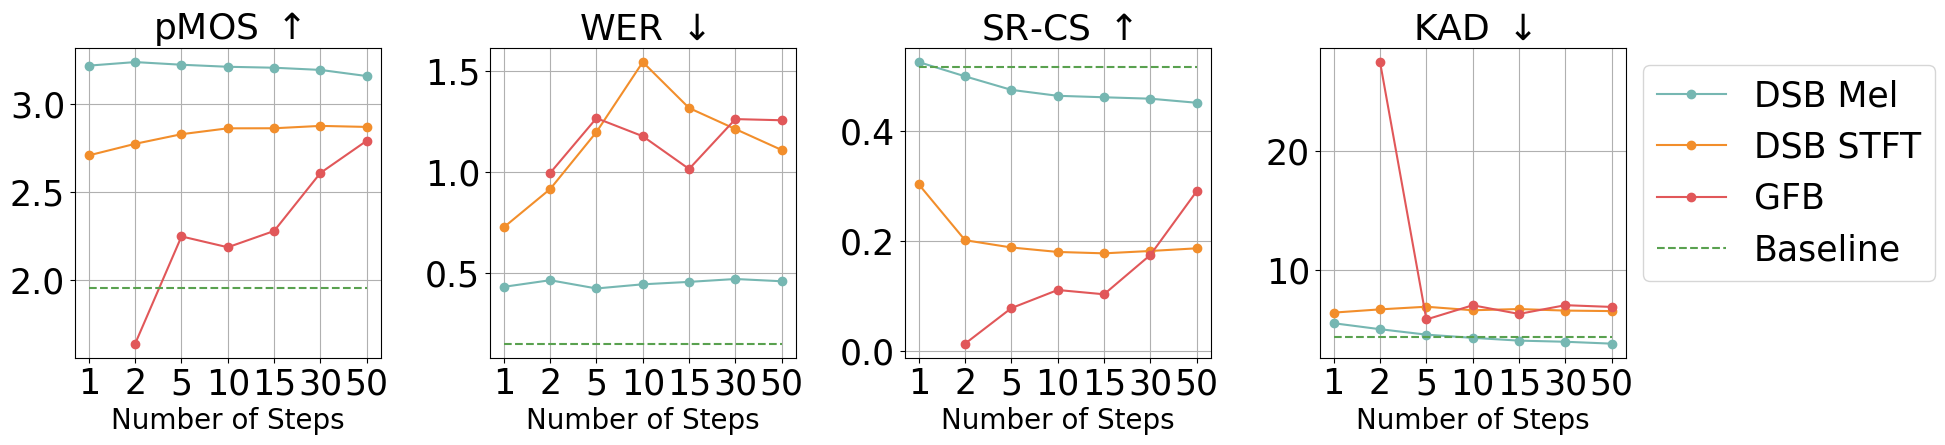

In [78]:
import matplotlib.pyplot as plt
import torch

data = dict()
what_test = "rir"

num_steps = [1, 2, 5, 10, 15, 30, 50]  # reversed order for plotting
for model in ['esdsb_sto', 'stft_sto', 'gfb', 'baseline']:
    data[model] = dict()
    for metric in ['dnsmos', 'wer', 'srcs', 'kad', 'mcd']:
        metric_dict = dict()
        for num_step in num_steps:
            if num_step == 1 and model == 'gfb':
                continue
            
            if model == 'baseline':
                path = f"test_results/test_{what_test}/baseline"
            else:
                path = f"test_results/test_{what_test}/{model}_{num_step}"
                
            metrics = torch.load(path + "/metrics.pt", weights_only=True)
            value = metrics[metric]
            value = torch.tensor(value)
            value = value.mean().item()
            
            metric_dict[num_step] = value
            
            if model == 'baseline':
                break

        data[model][metric] = metric_dict

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs = axs.flatten()  # type: ignore
axs : list[plt.Axes]
plt.rcParams.update({'font.size': 25})

for i, (model, metrics) in enumerate(data.items()):    
    if model == 'baseline':
        axs[0].hlines(y=metrics['dnsmos'].values(), linestyles='--', xmin=0, xmax=len(num_steps)-1, color=model_to_color[model])
        axs[1].hlines(y=metrics['wer'].values(), linestyles='--', xmin=0, xmax=len(num_steps)-1, color=model_to_color[model])
        axs[2].hlines(y=metrics['srcs'].values(), linestyles='--', xmin=0, xmax=len(num_steps)-1, color=model_to_color[model])
        axs[3].hlines(y=metrics['kad'].values(), linestyles='--', xmin=0, xmax=len(num_steps)-1, color=model_to_color[model], label=model_to_name[model])
        continue
    
    xvalues = range(len(num_steps)) if model != 'gfb' else range(1, len(num_steps))  # GFB does not have num_step=1
    axs[0].plot(xvalues, metrics['dnsmos'].values(), marker='o', linestyle='-', color=model_to_color[model])
    axs[1].plot(xvalues, metrics['wer'].values(), marker='o', linestyle='-', color=model_to_color[model])
    axs[2].plot(xvalues, metrics['srcs'].values(), marker='o', linestyle='-', color=model_to_color[model])
    axs[3].plot(xvalues, metrics['kad'].values(), marker='o', linestyle='-', color=model_to_color[model], label=model_to_name[model])
for i in range(4):
    axs[i].set_xlabel("Number of Steps", fontsize=20)
    axs[i].set_title([r"pMOS $\uparrow$", r"WER $\downarrow$", r"SR-CS $\uparrow$", r"KAD $\downarrow$"][i], fontsize=26)
    axs[i].grid(True)
    axs[i].set_xticks(range(len(num_steps)))
    axs[i].set_xticklabels(num_steps)
    if i == 3:
        axs[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"test_results/test_{what_test}/metrics.png", bbox_inches='tight', dpi=300)
plt.show()

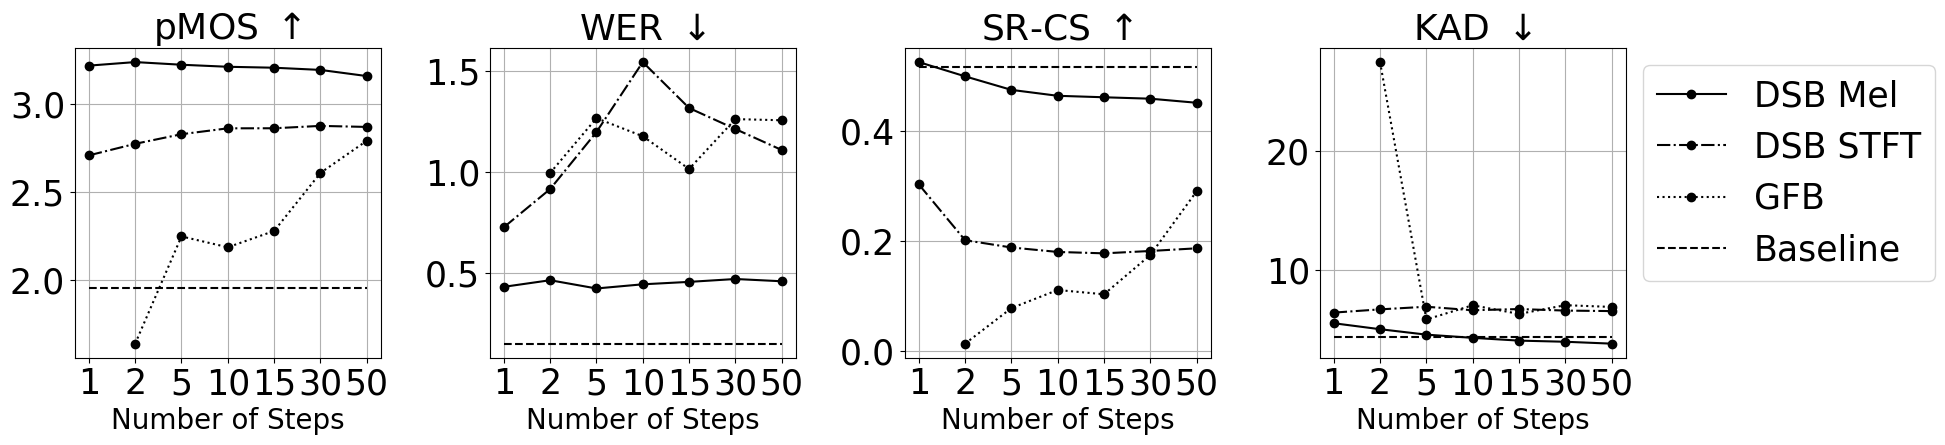

In [115]:
import matplotlib.pyplot as plt
import torch

data = dict()
what_test = "rir"

num_steps = [1, 2, 5, 10, 15, 30, 50]  # reversed order for plotting
for model in ['esdsb_sto', 'stft_sto', 'gfb', 'baseline']:
    data[model] = dict()
    for metric in ['dnsmos', 'wer', 'srcs', 'kad', 'mcd']:
        metric_dict = dict()
        for num_step in num_steps:
            if num_step == 1 and model == 'gfb':
                continue
            
            if model == 'baseline':
                path = f"test_results/test_{what_test}/baseline"
            else:
                path = f"test_results/test_{what_test}/{model}_{num_step}"
                
            metrics = torch.load(path + "/metrics.pt", weights_only=True)
            value = metrics[metric]
            value = torch.tensor(value)
            value = value.mean().item()
            
            metric_dict[num_step] = value
            
            if model == 'baseline':
                break

        data[model][metric] = metric_dict

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs = axs.flatten()  # type: ignore
axs : list[plt.Axes]
plt.rcParams.update({'font.size': 25})

model_to_linestyle = {
    'esdsb_sto': '-',
    'stft_sto': '-.',
    'gfb': ':',
    'baseline': '--',
}

for i, (model, metrics) in enumerate(data.items()):    
    if model == 'baseline':
        axs[0].hlines(y=metrics['dnsmos'].values(), linestyle=model_to_linestyle[model], xmin=0, xmax=len(num_steps)-1, color="black")
        axs[1].hlines(y=metrics['wer'].values(), linestyle=model_to_linestyle[model], xmin=0, xmax=len(num_steps)-1, color="black")
        axs[2].hlines(y=metrics['srcs'].values(), linestyle=model_to_linestyle[model], xmin=0, xmax=len(num_steps)-1, color="black")
        axs[3].hlines(y=metrics['kad'].values(), linestyle=model_to_linestyle[model], xmin=0, xmax=len(num_steps)-1, label=model_to_name[model], color="black")
        continue
    
    xvalues = range(len(num_steps)) if model != 'gfb' else range(1, len(num_steps))  # GFB does not have num_step=1
    axs[0].plot(xvalues, metrics['dnsmos'].values(), marker='o', linestyle=model_to_linestyle[model], color="black")
    axs[1].plot(xvalues, metrics['wer'].values(), marker='o', linestyle=model_to_linestyle[model], color="black")
    axs[2].plot(xvalues, metrics['srcs'].values(), marker='o', linestyle=model_to_linestyle[model], color="black")
    axs[3].plot(xvalues, metrics['kad'].values(), marker='o', linestyle=model_to_linestyle[model], label=model_to_name[model], color="black")
for i in range(4):
    axs[i].set_xlabel("Number of Steps", fontsize=20)
    axs[i].set_title([r"pMOS $\uparrow$", r"WER $\downarrow$", r"SR-CS $\uparrow$", r"KAD $\downarrow$"][i], fontsize=26)
    axs[i].grid(True)
    axs[i].set_xticks(range(len(num_steps)))
    axs[i].set_xticklabels(num_steps)
    if i == 3:
        axs[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"test_results/test_{what_test}/metrics_BW.png", bbox_inches='tight', dpi=300)
plt.show()

In [6]:
def siunitx(mean, error, decimals=2):
    mean_fmt = f"{mean:.{decimals}f}"
    err_scaled = int(round(error * 10**decimals))
    return rf"\num{{{mean_fmt}({err_scaled})}}"

In [7]:
# make it easy to copy paste the results to txt file
import torch

n_digits = 2

what_test = 'clip'
which_models = {
    'esdsb_sto_1': 'DSB Mel (1 step) (U)',
    'esdsb_sto_50': 'DSB Mel (50 steps) (U)',
    'esdsb_det_50': 'DSB Mel Deterministic (50 steps) (U)',
    'stft_sto_1': 'DSB STFT (1 step) (U)',
    'stft_sto_50': 'DSB STFT (50 steps) (U)',
    'gfb_2': 'GFB (2 steps) (U)',
    'gfb_50': 'GFB (50 steps) (U)',
    'SPADE': 'SPADE (SP)',
    'baseline': r'\textit{Baseline (unprocessed)}',
}

for model in which_models:
    metrics = torch.load(f"test_results/test_{what_test}/{model}/metrics.pt", weights_only=False)
    mos = torch.tensor(metrics['dnsmos'])
    wer = torch.tensor(metrics['wer'])
    srcs = torch.tensor(metrics['srcs'])
    kad = torch.tensor(metrics['kad'])
    mcd = torch.tensor(metrics['mcd'])

    print("&", which_models[model].ljust(37), end=" & ")
    for m in [mos, wer, srcs, mcd]:
        mean = m.mean().item()
        err = m.std().divide(len(m) ** 0.5).item()
        string = f"${siunitx(mean, err, n_digits)}$ &".ljust(30)
        print(string, end="")

    # kad doesn't have se
    mean = kad.mean().item()
    print(f"${mean:.{n_digits + 1}}$ \\\\")

& DSB Mel (1 step) (U)                  & $\num{3.19(1)}$ &             $\num{0.23(1)}$ &             $\num{0.52(1)}$ &             $\num{25.12(22)}$ &           $5.06$ \\
& DSB Mel (50 steps) (U)                & $\num{3.11(2)}$ &             $\num{0.42(2)}$ &             $\num{0.46(1)}$ &             $\num{28.91(28)}$ &           $2.05$ \\
& DSB Mel Deterministic (50 steps) (U)  & $\num{2.80(3)}$ &             $\num{0.32(2)}$ &             $\num{0.43(1)}$ &             $\num{27.59(27)}$ &           $4.88$ \\
& DSB STFT (1 step) (U)                 & $\num{3.13(1)}$ &             $\num{0.19(1)}$ &             $\num{0.46(1)}$ &             $\num{39.22(19)}$ &           $6.43$ \\
& DSB STFT (50 steps) (U)               & $\num{2.64(2)}$ &             $\num{1.16(11)}$ &            $\num{0.21(1)}$ &             $\num{41.38(31)}$ &           $7.89$ \\
& GFB (2 steps) (U)                     & $\num{1.74(1)}$ &             $\num{0.99(0)}$ &             $\num{0.05(0)}$ &             $\num{68

In [ ]:
what_test = "noise"

which_models = {
    'esdsb_sto_1': 'DSB Mel (1)',
    'esdsb_sto_50': 'DSB Mel (50)',
    'esdsb_det_50': 'DSB Mel Det. (50)',
    'stft_sto_1': 'DSB STFT (1)',
    'stft_sto_50': 'DSB STFT (50)',
    'sepformer': 'SepFormer',
    'convtasnet': 'ConvTasNet',
    'baseline': r'\textit{Baseline}',
}

for model in which_models.keys():
    path = f"test_results/test_{what_test}/{model}/metrics.pt"
    metrics = torch.load(path, weights_only=True)
    match model:
        case 'sepformer' | 'convtasnet':
            t = "P"
        case 'baseline':
            t = " "
        case _:
            t = "U"
    print(f" & {t} & ", which_models[model].ljust(35), end=" & ")

    sisdri = torch.tensor(metrics['dnsmos'])
    sisdrimean = sisdri.mean().item()
    sisdrierr = sisdri.std().divide(len(sisdri) ** 0.5).item()
    
    dnsmos = torch.tensor(metrics['sisdri'])
    dnsmosmean = dnsmos.mean().item()
    dnsmoserr = dnsmos.std().divide(len(dnsmos) ** 0.5).item()
    
    print(f"{siunitx(sisdrimean, sisdrierr).ljust(20)} & {siunitx(dnsmosmean, dnsmoserr)} \\\\")

 & U &  DSB Mel (1)                         & \num{3.22(1)}        & \num{-31.22(63)} \\
 & U &  DSB Mel (50)                        & \num{3.21(1)}        & \num{-31.86(63)} \\
 & U &  DSB STFT (1)                        & \num{2.74(2)}        & \num{5.39(11)} \\
 & U &  DSB Mel Deterministic (50)          & \num{3.01(3)}        & \num{-32.61(67)} \\
 & U &  DSB STFT (50)                       & \num{2.93(2)}        & \num{2.72(10)} \\
 & P &  SepFormer                           & \num{3.04(2)}        & \num{8.16(21)} \\
 & P &  ConvTasNet                          & \num{2.96(2)}        & \num{8.38(11)} \\
 &   &  \textit{Baseline}                   & \num{1.44(2)}        & \num{0.00(0)} \\


In [17]:

# make it easy to copy paste the results to txt file
import torch

n_digits = 2

what_test = 'rir'
which_models = {
    'esdsb_sto_1': 'DSB Mel (1 step) (U)',
    'esdsb_sto_50': 'DSB Mel (50 steps) (U)',
    'esdsb_det_50': 'DSB Mel Deterministic (50 steps) (U)',
    'stft_sto_1': 'DSB STFT (1 step) (U)',
    'stft_sto_50': 'DSB STFT (50 steps) (U)',
    'gfb_2': 'GFB (2 steps) (U)',
    'gfb_50': 'GFB (50 steps) (U)',
    'WPE': 'WPE (SP)',
    'baseline': r'\textit{Baseline (unprocessed)}',
}

for model in which_models:
    metrics = torch.load(f"test_results/test_{what_test}/{model}/metrics.pt", weights_only=False)
    mos = torch.tensor(metrics['dnsmos'])
    wer = torch.tensor(metrics['wer'])
    srcs = torch.tensor(metrics['srcs'])
    kad = torch.tensor(metrics['kad'])
    mcd = torch.tensor(metrics['mcd'])

    print("&", which_models[model].ljust(36), end=" & ")
    for m in [mos, wer, srcs, mcd]:
        mean = m.mean().item()
        err = m.std().divide(len(m) ** 0.5).item()
        string = f"${siunitx(mean, err, n_digits)}$ &".ljust(30)
        print(string, end="")

    # kad doesn't have se
    mean = kad.mean().item()
    print(f"${mean:.{n_digits + 1}}$ \\\\")

& DSB Mel (1 step) (U)                 & $\num{3.22(2)}$ &             $\num{0.43(11)}$ &            $\num{0.53(1)}$ &             $\num{64.99(85)}$ &           $5.58$ \\
& DSB Mel (50 steps) (U)               & $\num{3.16(2)}$ &             $\num{0.46(2)}$ &             $\num{0.45(1)}$ &             $\num{66.46(87)}$ &           $3.87$ \\
& DSB Mel Deterministic (50 steps) (U) & $\num{3.02(2)}$ &             $\num{0.47(2)}$ &             $\num{0.41(1)}$ &             $\num{68.47(90)}$ &           $6.82$ \\
& DSB STFT (1 step) (U)                & $\num{2.71(2)}$ &             $\num{0.73(14)}$ &            $\num{0.30(1)}$ &             $\num{86.92(108)}$ &          $6.47$ \\
& DSB STFT (50 steps) (U)              & $\num{2.87(2)}$ &             $\num{1.11(3)}$ &             $\num{0.19(1)}$ &             $\num{81.01(79)}$ &           $6.59$ \\
& GFB (2 steps) (U)                    & $\num{1.64(1)}$ &             $\num{0.99(0)}$ &             $\num{0.01(0)}$ &             $\num{61.65(51

In [18]:
# make it easy to copy paste the results to txt file
import torch

n_digits = 2

what_test = 'noise'
which_models = {
    'esdsb_sto_1': 'DSB Mel (1 step)',
    'esdsb_sto_50': 'DSB Mel (50 steps)',
    'stft_sto_1': 'DSB STFT (1)',
    'esdsb_det_50': 'DSB Mel Deterministic (50 steps)',
    'stft_sto_50': 'DSB STFT (50 steps)',
    'sepformer': 'SepFormer',
    'convtasnet': 'ConvTasNet',
    'baseline': r'\textit{Baseline (unprocessed)}',
}

for model in which_models:
    metrics = torch.load(f"test_results/test_{what_test}/{model}/metrics.pt", weights_only=False)
    mos = torch.tensor(metrics['dnsmos'])
    wer = torch.tensor(metrics['wer'])
    srcs = torch.tensor(metrics['srcs'])
    kad = torch.tensor(metrics['kad'])
    sisdr = torch.tensor(metrics['sisdri'])
    mcd = torch.tensor(metrics['mcd'])

    print("&", which_models[model].ljust(35), end=" & ")
    for m in [mos, wer, srcs, mcd]:
        mean = m.mean().item()
        err = m.std().divide(len(m) ** 0.5).item()
        string = f"${siunitx(mean, err, n_digits)}$ &".ljust(30)
        print(string, end="")

    # kad doesn't have se
    mean = kad.mean().item()
    print(f"${mean:.{n_digits + 1}}$ \\\\")

& DSB Mel (1 step)                    & $\num{3.22(1)}$ &             $\num{0.52(11)}$ &            $\num{0.55(1)}$ &             $\num{40.00(42)}$ &           $5.5$ \\
& DSB Mel (50 steps)                  & $\num{3.21(1)}$ &             $\num{0.76(11)}$ &            $\num{0.44(1)}$ &             $\num{43.33(43)}$ &           $4.39$ \\
& DSB STFT (1)                        & $\num{2.74(2)}$ &             $\num{0.22(2)}$ &             $\num{0.50(1)}$ &             $\num{49.71(33)}$ &           $4.15$ \\
& DSB Mel Deterministic (50 steps)    & $\num{3.01(3)}$ &             $\num{0.73(11)}$ &            $\num{0.42(1)}$ &             $\num{42.25(52)}$ &           $6.15$ \\
& DSB STFT (50 steps)                 & $\num{2.93(2)}$ &             $\num{1.04(17)}$ &            $\num{0.30(1)}$ &             $\num{53.43(50)}$ &           $5.26$ \\
& SepFormer                           & $\num{3.04(2)}$ &             $\num{0.16(2)}$ &             $\num{0.69(1)}$ &             $\num{31.86(27)}$ &  

In [16]:
# investigate trajectory curvature

import torch
from src.callbacks.metrics import calculate_curvature_displacement
from torch import Tensor

def calculate_gfb_curvature_from_path(path : str, max_num_batches : int, direction : str) -> tuple[Tensor, Tensor]:
    batches = load_all_batches(path, max_num_batches)
    params = torch.load(path + "/params.pt", weights_only=True)
    timeschedule = params['timeschedule']
    timeschedule = torch.cat([torch.tensor([0.0]), timeschedule], dim=0)
    trajectories = batches['trajectory']
    forward_trajectory, backwrd_trajectory = trajectories.chunk(2, dim=0)
    
    if direction == 'forward':
        return calculate_curvature_displacement(forward_trajectory, timeschedule), timeschedule
    elif direction == 'backward':
        return calculate_curvature_displacement(backwrd_trajectory, timeschedule), timeschedule

def calculate_dsb_curvature_from_path(path : str, max_num_batches : int) -> Tensor:
    batches = load_all_batches(path, max_num_batches)
    params = torch.load(path + "/params.pt", weights_only=True)
    timeschedule = params['timeschedule']
    
    if isinstance(timeschedule, list):
        timeschedule = [t for t, _ in timeschedule] + [timeschedule[-1][1]]
        timeschedule = torch.tensor(timeschedule)

    trajectories = batches['trajectory']
    return calculate_curvature_displacement(trajectories, timeschedule), timeschedule

models = ['gfb', 'stft']
data : dict[str, tuple[Tensor, Tensor]] = dict()
n_batches = 1

for model in models:
    data[model] = dict()

    path = f"test_results/test_traj/{model}"
    
    if model == 'gfb':
        cts_forward, timeschedule = calculate_gfb_curvature_from_path(path, max_num_batches=n_batches, direction='forward')
        cts_backward, _ = calculate_gfb_curvature_from_path(path, max_num_batches=n_batches, direction='backward')
        data['gfb_forward'] = cts_forward, timeschedule
        data['gfb_backward'] = cts_backward, timeschedule
    else:
        cts, timeschedule = calculate_dsb_curvature_from_path(path, max_num_batches=n_batches)
        data['dsb'] = cts, timeschedule


import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize=(10, 7))

stft_traj = data['dsb'][0]
stft_traj = stft_traj.flip(dims=[1])
stft_mean = stft_traj.mean(dim=0)
stft_std = stft_traj.std(dim=0)
timeschedule = torch.linspace(0, 1, steps=stft_traj.shape[1])  # create a timeschedule from 0 to 1

ax.plot(timeschedule, stft_mean, label="DSB (STFT)", color=model_to_color['stft_det'])
ax.fill_between(timeschedule, stft_mean - stft_std, stft_mean + stft_std, alpha=0.2, color=model_to_color['stft_det'])

ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xticklabels([1, 0.75, 0.5, 0.25, 0])
ax.set_xlabel("$t$ (DSB)")

ax2 = ax.twiny()  # create a second y-axis

forward_traj = data['gfb_forward'][0]
backward_traj = data['gfb_backward'][0]
timeschedule = torch.linspace(0, 1, steps=forward_traj.shape[1])  # create a timeschedule from 0 to 1

forward_mean = forward_traj.mean(dim=0)
forward_std = forward_traj.std(dim=0)
backward_mean = backward_traj.mean(dim=0)
backward_std = backward_traj.std(dim=0)

ax2.plot(timeschedule, forward_mean, color=model_to_color['gfb'])
ax2.plot(timeschedule + 1, backward_mean, label="GFB (forward and backward)", color=model_to_color['gfb'])
ax2.fill_between(timeschedule, forward_mean - forward_std, forward_mean + forward_std, alpha=0.2, color=model_to_color['gfb'])
ax2.fill_between(timeschedule + 1, backward_mean - backward_std, backward_mean + backward_std, alpha=0.2, color=model_to_color['gfb'])

# right now, x-axis goes from 0 to 2
# make the ticks look like they go from 0 to 1 and back to 0
ax2.set_xticks([0, 0.5, 1, 1.5, 2])
ax2.set_xticklabels([0, 0.5, 1, 0.5, 0])

ax2.set_xlabel("$t$ (GFB)")

ax.set_ylabel("$C(t)$")
fig.legend(loc='upper right', bbox_to_anchor=(1.8, 1), bbox_transform=ax.transAxes)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"test_results/test_clip/curvature.png", bbox_inches='tight', dpi=300)
plt.show()

KeyboardInterrupt: 

In [ ]:
import os
import torchaudio

path = "/work3/s214630/Latent-DSB/audio_samples/"
os.makedirs(path, exist_ok=True)
n_samples = 5

for experiment in ['clip', 'rir']:
    if experiment == 'clip':
        models = ['baseline', 'esdsb_sto_1', 'esdsb_sto_50', 'stft_sto_50', 'gfb_50', 'SPADE']
    elif experiment == 'rir':
        models =  ['baseline', 'esdsb_sto_1', 'esdsb_sto_50', 'stft_sto_50', 'gfb_50', 'WPE']
        
    for model in models:
        if model == 'baseline':
            samples_path = f"test_results/test_{experiment}/baseline"
            batches = load_all_batches(samples_path, max_num_batches=3)
            x0, x1 = batches['x0'], batches['x1']
            for i in range(n_samples):
                torchaudio.save(os.path.join(path, f"{experiment}_{model}_x0_{i}.wav"), x0[i].squeeze().unsqueeze(0), 16000)
                torchaudio.save(os.path.join(path, f"{experiment}_{model}_x1_{i}.wav"), x1[i].squeeze().unsqueeze(0), 16000)
            
        else:
            samples_path = f"test_results/test_{experiment}/{model}"
            batches = load_all_batches(samples_path, max_num_batches=1)
            x0_recon = batches['x0_recon']
            for i in range(n_samples):
                torchaudio.save(os.path.join(path, f"{experiment}_{model}_x0_recon_{i}.wav"), x0_recon[i].squeeze().unsqueeze(0), 16000)
                
experiment = 'noise'
for model in ['baseline', 'esdsb_sto_1', 'esdsb_sto_50', 'sepformer', 'convtasnet']:
    if model == 'baseline':
        samples_path = f"test_results/test_{experiment}/baseline"
        batches = load_all_batches(samples_path, max_num_batches=1)
        x0, x1 = batches['x0'], batches['x1']
        for i in range(n_samples):
            torchaudio.save(os.path.join(path, f"{experiment}_{model}_x0_{i}.wav"), x0[i].squeeze().unsqueeze(0), 16000)
            torchaudio.save(os.path.join(path, f"{experiment}_{model}_x1_{i}.wav"), x1[i].squeeze().unsqueeze(0), 16000)
        
    else:
        samples_path = f"test_results/test_{experiment}/{model}"
        batches = load_all_batches(samples_path, max_num_batches=1)
        x0_recon = batches['x0_recon']
        for i in range(n_samples):
            torchaudio.save(os.path.join(path, f"{experiment}_{model}_x0_recon_{i}.wav"), x0_recon[i].squeeze().unsqueeze(0), 16000)


In [9]:
# test noise factor
import torch

xs = [i / 10 for i in range(21)]
data = {}
for metric in ['dnsmos', 'wer', 'srcs', 'kad']:
    means = []
    stds = []
    for i, noise_factor in enumerate(xs):
        path = f'/work3/s214630/Latent-DSB/test_results/test_noise_factor/esdsb_sto_{noise_factor}'
        metrics = torch.load(path + "/metrics.pt", weights_only=False)
        value = metrics[metric]
        value = torch.tensor(value)
        value_mean = value.mean().item()
        if metric == 'kad':
            means.append(value_mean)
        else:
            std = value.std().item()
            se = std / len(value) ** 0.5
            means.append(value_mean)
            stds.append(std)
    data[metric] = (means, stds)


[2.8774588108062744, 2.590258836746216, 2.757969379425049, 3.123750925064087, 3.204604387283325, 3.266911029815674, 3.273447036743164, 3.2713873386383057, 3.286559820175171, 3.2752020359039307, 3.2328219413757324, 2.9779889583587646, 2.635948657989502, 2.323276996612549, 2.0749049186706543, 1.8595901727676392, 1.6757006645202637, 1.5688227415084839, 1.4757139682769775, 1.4070485830307007, 1.3663371801376343] [0.48762351274490356, 0.7006402611732483, 0.5779147744178772, 0.31183508038520813, 0.24897609651088715, 0.18962273001670837, 0.18520839512348175, 0.19383545219898224, 0.19945089519023895, 0.19632934033870697, 0.20814663171768188, 0.25230899453163147, 0.30751264095306396, 0.3415473997592926, 0.3238092362880707, 0.29880425333976746, 0.2776610255241394, 0.2365874946117401, 0.19870203733444214, 0.16745033860206604, 0.14591935276985168]
[0.34970998764038086, 0.3611624240875244, 0.36378294229507446, 0.369843065738678, 0.3699488341808319, 0.36876118183135986, 0.3672127425670624, 0.3593874

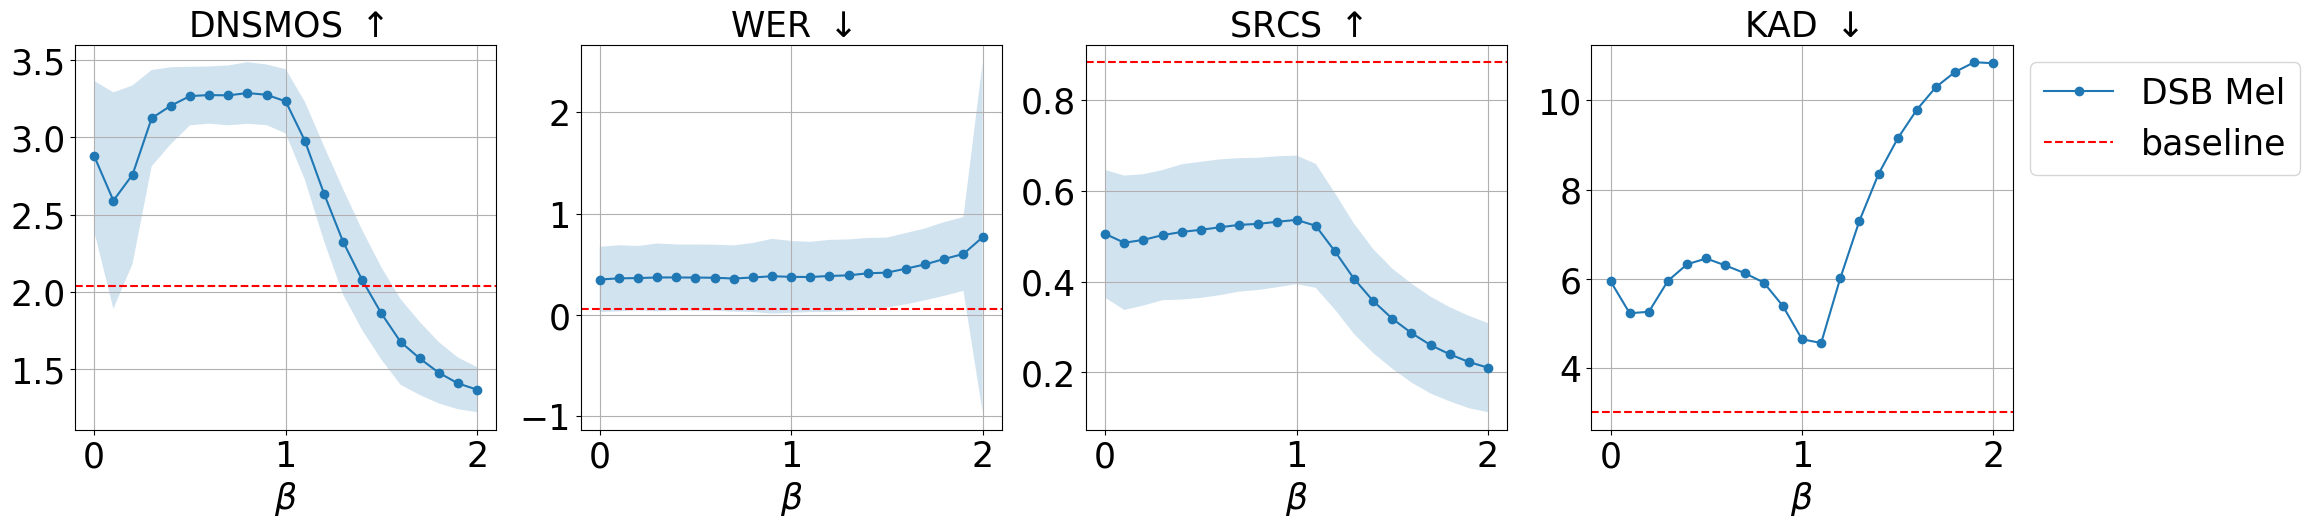

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(25, 5))
axs : list[plt.Axes]

plt.rcParams.update({'font.size': 25})

baseline = torch.load('/work3/s214630/Latent-DSB/test_results/test_noise/baseline/metrics.pt', weights_only=False)

for i, metric in enumerate(['dnsmos', 'wer', 'srcs', 'kad']):
    title = [r"DNSMOS $\uparrow$", r"WER $\downarrow$", r"SRCS $\uparrow$", r"KAD $\downarrow$"][i]
    means, se = data[metric.lower()]
    print(means, se)
    axs[i].plot(xs, means, marker='o', label="DSB Mel")
    if metric != 'kad':
        axs[i].fill_between(xs, [m - s for m, s in zip(means, se)], [m + s for m, s in zip(means, se)], alpha=0.2, label="Std.dev.")
    axs[i].set_title(title, fontsize=25)
    axs[i].grid(True)
    axs[i].set_xlabel(r'$\beta$')
    
    if metric == 'wer':
        baseline_val = torch.tensor(baseline['wer']).mean().item()
    if metric == 'srcs':
        baseline_val = torch.tensor(baseline['srcs']).mean().item()
    if metric == 'dnsmos':
        baseline_val = torch.tensor(baseline['dnsmos']).mean().item()
    if metric == 'kad':
        baseline_val = torch.tensor(baseline['kad']).mean().item()
        
    label = 'baseline' if i == 3 else None
    axs[i].axhline(y=baseline_val, linestyle='--', color='r', label=label)

plt.legend(loc='upper left', fontsize=25, bbox_to_anchor=(1.0, 1))
plt.savefig(f"test_results/test_noise_factor/noise_factor.png", bbox_inches='tight', dpi=300)